#### Leo Archivos

In [8]:
import numpy as np
from astropy.io import ascii


# Read UHECR
filename_e = '../data/Auger/events_a8_lb.dat'
events_a8 = ascii.read(filename_e)

# Read Gxs
filename_g = '../data/VLS/2MRSxWISE_VLS.txt'
data = ascii.read(filename_g)

print('Gxs DEC range:%5.2fdeg - %5.2fdeg' % (data['_DEJ2000'].min(),data['_DEJ2000'].max()))
print('Gxs RA range:%5.2fdeg - %5.2fdeg' % (data['_RAJ2000'].min(),data['_RAJ2000'].max()))

print('UHECR DEC range:%5.2fdeg - %5.2fdeg' % (events_a8['dec'].min(),events_a8['dec'].max()))
print('UHECR RA range:%5.2fdeg - %5.2fdeg' % (events_a8['RA'].min(),events_a8['RA'].max()))


Gxs DEC range:-87.77deg - 44.95deg
Gxs RA range: 0.81deg - 359.86deg
UHECR DEC range:-89.90deg - 44.70deg
UHECR RA range: 0.00deg - 360.00deg


#### Genero catalogos random

In [9]:
ra_min = np.min(data['_RAJ2000'])
ra_max = np.max(data['_RAJ2000'])
dec_min = np.min(data['_DEJ2000'])
dec_max = np.max(data['_DEJ2000'])
print('ra range = %f .. %f' % (ra_min, ra_max))
print('dec range = %f .. %f' % (dec_min, dec_max))

np.random.seed(12837612)
ntot = len(data['_DEJ2000'])
rand_ra1 = np.random.uniform(ra_min, ra_max, ntot*50)
rand_sindec1 = np.random.uniform(np.sin(dec_min*np.pi/180.), np.sin(dec_max*np.pi/180.), ntot*50)
rand_dec1 = np.arcsin(rand_sindec1)
print('ran1 ra range = %f .. %f' % (rand_ra1.min(), rand_ra1.max()))
print('ran1 dec range = %f .. %f' % (rand_dec1.min(), rand_dec1.max()))


np.random.seed(12837613)
rand_ra2 = np.random.uniform(ra_min, ra_max, ntot*50)
rand_sindec2 = np.random.uniform(np.sin(dec_min*np.pi/180.), np.sin(dec_max*np.pi/180.), ntot*50)
rand_dec2 = np.arcsin(rand_sindec2)
print('ran2 ra range = %f .. %f' % (rand_ra2.min(), rand_ra2.max()))
print('ran2 dec range = %f .. %f' % (rand_dec2.min(), rand_dec2.max()))

ra range = 0.812280 .. 359.856260
dec range = -87.772240 .. 44.954860
ran1 ra range = 0.820602 .. 359.847675
ran1 dec range = -1.531422 .. 0.784500
ran2 ra range = 0.812965 .. 359.848555
ran2 dec range = -1.531389 .. 0.784600


#### Ploteo todo por las dudas

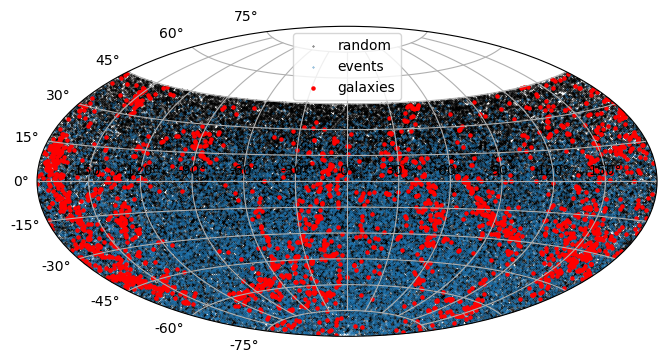

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u

gxs = SkyCoord(data['_RAJ2000'],data['_DEJ2000'],frame='icrs',unit='degree')
eve = SkyCoord(events_a8['RA'],events_a8['dec'],frame='icrs',unit='degree')
ran = SkyCoord(rand_ra1,rand_dec1,frame='icrs',unit='rad')

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="aitoff")
ax.scatter(ran.ra.wrap_at(180*u.degree).to(u.rad),ran.dec.to(u.rad),s=.1,c='k',label='random')
ax.scatter(eve.ra.wrap_at(180*u.degree).to(u.rad),eve.dec.to(u.rad),s=.1,label='events')
ax.scatter(gxs.ra.wrap_at(180*u.degree).to(u.rad),gxs.dec.to(u.rad),s=5,c='r',label='galaxies')
ax.legend()
ax.grid(True)
plt.show()

#### Autocorrelacion

[ 0.91647271  0.65871051  0.52163724  0.35016863  0.20347355 -0.01185097
 -0.01162136  0.08429358 -0.09121734 -0.28892115 -0.29925709 -0.27280573
 -0.17199198 -0.21778219]


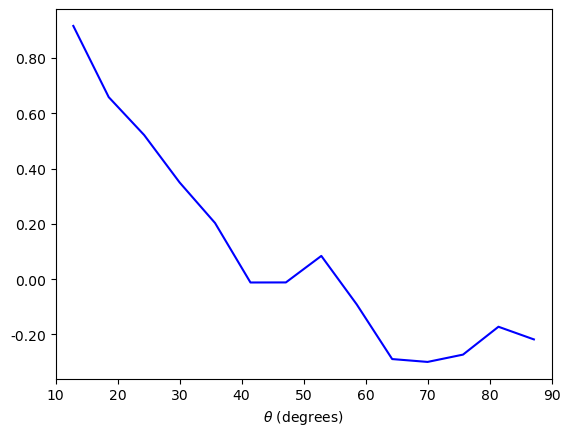

In [11]:
import numpy as np
import Corrfunc
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.utils import convert_3d_counts_to_cf
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as mtick

bins = np.linspace(10., 90., 15)
nthreads = 1

DD = DDtheta_mocks(autocorr=1,RA1=data['_RAJ2000'],DEC1=data['_DEJ2000'],binfile=bins,nthreads=nthreads)

DR = DDtheta_mocks(autocorr=0,RA1=data['_RAJ2000'],DEC1=data['_DEJ2000'],RA2=rand_ra1,DEC2=rand_dec1,binfile=bins,nthreads=nthreads)

RR = DDtheta_mocks(autocorr=1,RA1=rand_ra1,DEC1=rand_dec1,binfile=bins,nthreads=nthreads)

Nd = len(data)
#Nd2 = len(events_a8)
Nr = len(rand_ra1)
DDnorm = DD['npairs']/(Nd*(Nd-1))
DRnorm = DR['npairs']/(Nd*Nr)
RRnorm = RR['npairs']/(Nr*(Nr-1))

ls = (DDnorm-2*DRnorm+RRnorm)/RRnorm

cf = convert_3d_counts_to_cf(len(data), len(events_a8), len(rand_ra1), len(rand_ra1),
                             D1D2=DD, D1R2=DR,
                             D2R1=DR, R1R2=RR)
print(ls)


fig, ax = plt.subplots()

r = (bins[1:] + bins[:-1]) / 2

pnoise = (1+ls)/np.sqrt(DD['npairs'])

np.savez('../data/corrfunc.npz',r,ls,pnoise)

ax.plot(r, ls, color='blue')
#ax.plot(r, -cf, color='blue', ls=':')
#ax.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=1)
#ax.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=1)
#leg = ax.errorbar(-r, xi, yerr=sig, color='blue')

#ax.set_xscale('log')
#ax.set_yscale('log', nonpositive='clip')
ax.set_xlabel(r'$\theta$ (degrees)')

#ax.legend([leg], [r'$w(\theta)$'], loc='lower left')
ax.set_xlim([10,90])

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
#ax.xaxis.set_minor_formatter(mtick.FormatStrFormatter('%.0f'))

#plt.axis

plt.show()

#### Crosscorrelation

In [5]:
autocorr = 0
bins = np.geomspace(10., 90., 15)
nthreads = 2

D1D2 = DDtheta_mocks(autocorr=0,RA1=data['_RAJ2000'],DEC1=data['_DEJ2000'],RA2=events_a8['RA'],DEC2=events_a8['dec'],binfile=bins,nthreads=nthreads)

D1R2 = DDtheta_mocks(autocorr=0,RA1=data['_RAJ2000'],DEC1=data['_DEJ2000'],RA2=rand_ra1,DEC2=rand_dec1,binfile=bins,nthreads=nthreads)

D2R1 = DDtheta_mocks(autocorr=0,RA1=events_a8['RA'],DEC1=events_a8['dec'],RA2=rand_ra1,DEC2=rand_dec1,binfile=bins,nthreads=nthreads)

R1R2 = DDtheta_mocks(autocorr=0,RA1=rand_ra1,DEC1=rand_dec1,RA2=rand_ra2,DEC2=rand_dec2,binfile=bins,nthreads=nthreads)


In [6]:
from Corrfunc.utils import convert_3d_counts_to_cf

cf = convert_3d_counts_to_cf(len(data), len(events_a8), len(rand_ra1), len(rand_ra2),
                             D1D2=D1D2, D1R2=D1R2,
                             D2R1=D2R1, R1R2=R1R2)
print(cf)

[ 0.77710137  0.71209747  0.66511384  0.6015733   0.54728783  0.47939258
  0.35013636  0.25034749  0.11814341  0.00399107  0.03724264 -0.11012612
 -0.22984036 -0.3279466 ]


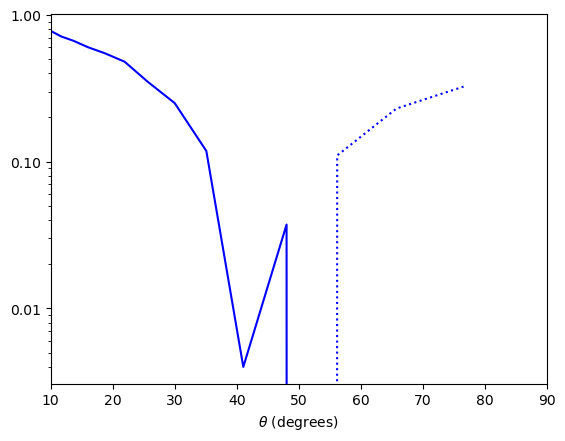

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as mtick

fig, ax = plt.subplots()

r = bins[:-1]

ax.plot(r, cf, color='blue')
ax.plot(r, -cf, color='blue', ls=':')
#ax.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=1)
#ax.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=1)
#leg = ax.errorbar(-r, xi, yerr=sig, color='blue')

#ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_xlabel(r'$\theta$ (degrees)')

#ax.legend([leg], [r'$w(\theta)$'], loc='lower left')
ax.set_xlim([10,90])

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
#ax.xaxis.set_minor_formatter(mtick.FormatStrFormatter('%.0f'))

#plt.axis

plt.show()